## Grid Search

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model’s generalization performance by tuning its parameters. We discussed the parameter settings of many of the algorithms in scikit-learn in Chapters 2 and 3, and it is important to understand what the parameters mean before trying to adjust them. Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. 

Because it is such a common task, there are standard methods in scikit-learn to help you with it. The most commonly used method is grid search, which basically means trying all possible combinations of the parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as implemented in the *SVC* class. As we discussed in Chapter 2, there are two important parameters: the kernel bandwidth, *gamma*, and the regularization parameter, *C*. 

Say we want to try the values 0.001, 0.01, 0.1, 1, 10, and 100 for the parameter C, and the same for gamma. Because we have six different settings for C and gamma that we want to try, we have 36 combinations of parameters in total. Looking at all possible combinations creates a table (or grid) of parameter settings for the SVM, as shown here:

%%HTML

<table>
    <tr>
      <th>&nbsp;</th>
      <th>C = 0.001</th>
      <th>C = 0.01</th>
      <th>…</th>
      <th>C = 10</th>
    </tr>
    <tr>
      <td>gamma=0.001</td>
	  <td>SVC(C=0.001, gamma=0.001)</td>
	  <td>SVC(C=0.01, gamma=0.001)</td>
      <td>…</td>
	  <td>SVC(C=10, gamma=0.001)</td>
    </tr>
    <tr>
      <td>gamma=0.01</td>
      <td>SVC(C=0.001, gamma=0.01)</td>
      <td>SVC(C=0.01, gamma=0.01)</td>
      <td>…</td>
      <td>SVC(C=10, gamma=0.01)</td>
    </tr>
    <tr>
      <td>…</td>
      <td>…</td>
      <td>…</td>
      <td>…</td>
      <td>…</td>
    </tr>
    <tr>
      <td>gamma=100</td>
      <td>SVC(C=0.001, gamma=100)</td>
      <td>SVC(C=0.01, gamma=100)</td>
      <td>…</td>
      <td>SVC(C=10, gamma=100)</td>
  </tr>

We can implement a simple grid search just as for loops over the two parameters, training and evaluating a classifier for each combination:

In [3]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
iris = load_iris()

In [5]:
# Naive grid search implementation
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # Evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### The Danger of Overfitting the Parameters and the Validation Set

Given this result, we might be tempted to report that we found a model that performs with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and selected the one with best accuracy on the test set, but this accuracy won’t necessarily carry over to new data. 

Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is. This is the same reason we needed to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the training set to build the model, the validation (or development) set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters. 

This figure shows what this looks like:

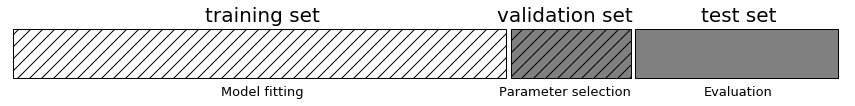

In [6]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data. This way, we can use as much data as possible to build our model. This leads to the following implementation:

In [7]:
# Split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# Split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # Evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# Rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably because we used less data to train the model (X_train is smaller now because we split our dataset twice). However, the score on the test set—the score that actually tells us how well we generalize—is even lower, at 92%. So we can only claim to classify new data 92% correctly, not 97% correctly as we thought before!

The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy “leak” information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. 

It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation—this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

### Grid Search with Cross-Validation

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split. From the output of the previous code snippet we can see that grid search selects 'C': 10, 'gamma': 0.001 as the best parameters, while the output of the code in the previous section selects 'C': 100, 'gamma': 0.001 as the best parameters. 

For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination. This method can be coded up as follows:

In [8]:
from sklearn.model_selection import cross_val_score

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # For each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        # Perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # Compute mean cross-validation accuracy
        score = np.mean(scores)
        # If we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# Rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To evaluate the accuracy of the SVM using a particular setting of C and gamma using five-fold cross-validation, we need to train 36 * 5 = 180 models. As you can imagine, the main downside of the use of cross-validation is the time it takes to train all these models.

The following visualization illustrates how the best parameter setting is selected in the preceding code:

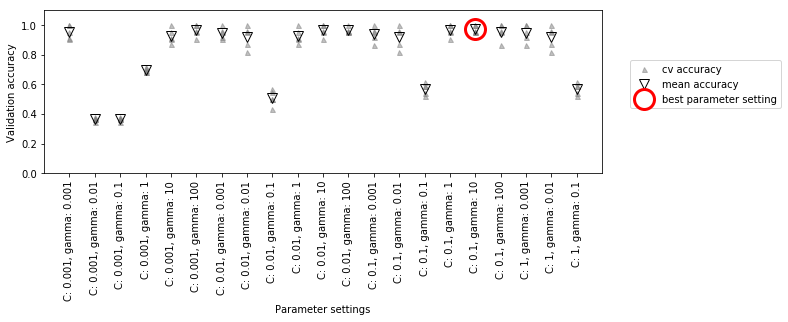

In [9]:
mglearn.plots.plot_cross_val_selection()

For each parameter setting (only a subset is shown), five accuracy values are computed, one for each split in the cross-validation. Then the mean validation accuracy is computed for each parameter setting. The parameters with the highest mean validation accuracy are chosen, marked by the circle.

#### Note

As we said earlier, cross-validation is a way to evaluate a given algorithm on a specific dataset. However, it is often used in conjunction with parameter search methods like grid search. For this reason, many people use the term *cross-validation* colloquially to refer to grid search with cross-validation.

The overall process of splitting the data, running the grid search, and evaluating the final parameters is illustrated here:

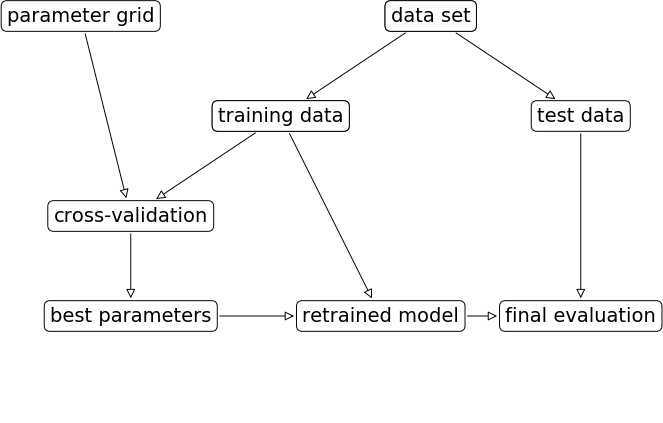

In [10]:
mglearn.plots.plot_grid_search_overview()

Because grid search with cross-validation is such a commonly used method to adjust parameters, scikit-learn provides the *GridSearchCV* class, which implements it in the form of an estimator. To use the *GridSearchCV* class, you first need to specify the parameters you want to search over using a dictionary. *GridSearchCV* will then perform all the necessary model fits. 

The keys of the dictionary are the names of parameters we want to adjust (as given when constructing the model—in this case, C and gamma), and the values are the parameter settings we want to try out. Trying the values 0.001, 0.01, 0.1, 1, 10, and 100 for C and gamma translates to the following dictionary:

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can now instantiate the *GridSearchCV* class with the model (*SVC*), the parameter grid to search (*param_grid*), and the cross-validation strategy we want to use (say, five-fold stratified cross-validation):

In [12]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

GridSearchCV will use cross-validation in place of the split into a training and validation set that we used before. However, we still need to split the data into a training and a test set, to avoid overfitting the parameters:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

The grid_search object that we created behaves just like a classifier; we can call the standard methods *fit*, *predict*, and *score* on it.  However, when we call *fit*, it will run cross-validation for each combination of parameters we specified in *param_grid*:

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Fitting the *GridSearchCV* object not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance. What happens in fit is therefore equivalent to the result of the code we saw at the beginning of this section. The *GridSearchCV* class provides a very convenient interface to access the retrained model using the predict and score methods. 

To evaluate how well the best found parameters generalize, we can call *score* on the test set:

In [15]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


Choosing the parameters using cross-validation, we actually found a model that achieves 97% accuracy on the test set. The important thing here is that we did not use the test set to choose the parameters. The parameters that were found are stored in the *best_params_* attribute, and the best cross-validation accuracy (the mean accuracy over the different splits for this parameter setting) is stored in *best_score_*:

In [16]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


#### Warning

Again, be careful not to confuse *best_score_* with the generalization performance of the model as computed by the score method on the test set. Using the *score* method (or evaluating the output of the predict method) employs a model trained on the whole training set. The *best_score_* attribute stores the mean cross-validation accuracy, with cross-validation performed on the training set.

Sometimes it is helpful to have access to the actual model that was found—for example, to look at coefficients or feature importances. You can access the model with the best parameters trained on the whole training set using the *best_estimator_* attribute:

In [17]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Because grid_search itself has predict and score methods, using *best_estimator_* is not needed to make predictions or evaluate the model.

### Analyzing the Result of Cross-Validation

It is often helpful to visualize the results of cross-validation, to understand how the model generalization depends on the parameters we are searching. As grid searches are quite computationally expensive to run, often it is a good idea to start with a relatively coarse and small grid. We can then inspect the results of the cross-validated grid search, and possibly expand our search. The results of a grid search can be found in the *cv_results_* attribute, which is a dictionary storing all aspects of the search. It contains a lot of details, as you can see in the following output, and is best looked at after converting it to a pandas *DataFrame*:

In [18]:
import pandas as pd

# Convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# Show the first 5 rows
display(results.head())

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.001501      0.000234         0.000668        0.000146   0.001   
1       0.001249      0.000037         0.000523        0.000019   0.001   
2       0.001932      0.000348         0.000839        0.000213   0.001   
3       0.001369      0.000243         0.000528        0.000048   0.001   
4       0.001338      0.000087         0.000577        0.000056   0.001   

  param_gamma                        params  split0_test_score  \
0       0.001  {'C': 0.001, 'gamma': 0.001}              0.375   
1        0.01   {'C': 0.001, 'gamma': 0.01}              0.375   
2         0.1    {'C': 0.001, 'gamma': 0.1}              0.375   
3           1      {'C': 0.001, 'gamma': 1}              0.375   
4          10     {'C': 0.001, 'gamma': 10}              0.375   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.347826           0.363636  ...         0.366071        0.011371   
1           0.347826           0.363636  ...         0.366071        0.011371   
2           0.347826           0.363636  ...         0.366071        0.011371   
3           0.347826           0.363636  ...         0.366071        0.011371   
4           0.347826           0.363636  ...         0.366071        0.011371   

   rank_test_score  split0_train_score  split1_train_score  \
0               22            0.363636            0.370787   
1               22            0.363636            0.370787   
2               22            0.363636            0.370787   
3               22            0.363636            0.370787   
4               22            0.363636            0.370787   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.366667            0.366667            0.362637   
1            0.366667            0.366667            0.362637   
2            0.366667            0.366667            0.362637   
3            0.366667            0.366667            0.362637   
4            0.366667            0.366667            0.362637   

   mean_train_score  std_train_score  
0          0.366079         0.002852  
1          0.366079         0.002852  
2          0.366079         0.002852  
3          0.366079         0.002852  
4          0.366079         0.002852  

[5 rows x 22 columns]

Each row in results corresponds to one particular parameter setting. For each setting, the results of all cross-validation splits are recorded, as well as the mean and standard deviation over all splits. As we were searching a two-dimensional grid of parameters (C and gamma), this is best visualized as a heat map. First we extract the mean validation scores, then we reshape the scores so that the axes correspond to C and gamma:

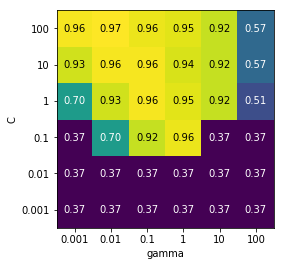

In [19]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# Plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

Each point in the heat map corresponds to one run of cross-validation, with a particular parameter setting. The color encodes the cross-validation accuracy, with light colors meaning high accuracy and dark colors meaning low accuracy. You can see that *SVC* is very sensitive to the setting of the parameters. 

For many of the parameter settings, the accuracy is around 40%, which is quite bad; for other settings the accuracy is around 96%. We can take away from this plot several things. First, the parameters we adjusted are very important for obtaining good performance. Both parameters (C and gamma) matter a lot, as adjusting them can change the accuracy from 40% to 96%. Additionally, the ranges we picked for the parameters are ranges in which we see significant changes in the outcome. It’s also important to note that the ranges for the parameters are large enough: the optimum values for each parameter are not on the edges of the plot.

Now let’s look at some plots where the result is less ideal, because the search ranges were not chosen properly:

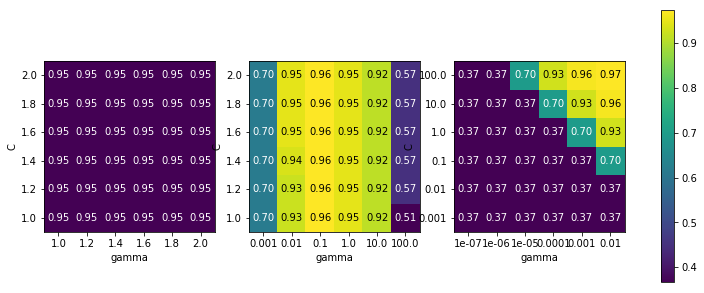

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # Plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

The first panel shows no changes at all, with a constant color over the whole parameter grid. In this case, this is caused by improper scaling and range of the parameters C and gamma. However, if no change in accuracy is visible over the different parameter settings, it could also be that a parameter is just not important at all. It is usually good to try very extreme values first, to see if there are any changes in the accuracy as a result of changing a parameter.

The second panel shows a vertical stripe pattern. This indicates that only the setting of the gamma parameter makes any difference. This could mean that the gamma parameter is searching over interesting values but the C parameter is not—or it could mean the C parameter is not important.

The third panel shows changes in both C and gamma. However, we can see that in the entire bottom left of the plot, nothing interesting is happening. We can probably exclude the very small values from future grid searches. The optimum parameter setting is at the top right. As the optimum is in the border of the plot, we can expect that there might be even better values beyond this border, and we might want to change our search range to include more parameters in this region.

Tuning the parameter grid based on the cross-validation scores is perfectly fine, and a good way to explore the importance of different parameters. However, you should not test different parameter ranges on the final test set—as we discussed earlier, evaluation of the test set should happen only once we know exactly what model we want to use.

### Search Over Spaces That Are Not Grids

In some cases, trying all possible combinations of all parameters as *GridSearchCV* usually does, is not a good idea. For example, SVC has a kernel parameter, and depending on which kernel is chosen, other parameters will be relevant. If *kernel='linear'*, the model is linear, and only the C parameter is used. If *kernel='rbf'*, both the C and gamma parameters are used (but not other parameters like degree). In this case, searching over all possible combinations of C, gamma, and kernel wouldn’t make sense: if *kernel='linear'*, gamma is not used, and trying different values for gamma would be a waste of time. 

To deal with these kinds of “conditional” parameters, *GridSearchCV* allows the *param_grid* to be a list of dictionaries. Each dictionary in the list is expanded into an independent grid. A possible grid search involving kernel and parameters could look like this:

In [21]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In the first grid, the kernel parameter is always set to 'rbf' (note that the entry for *kernel* is a list of length one), and both the C and *gamma* parameters are varied. In the second grid, the kernel parameter is always set to linear, and only C is varied. Now let’s apply this more complex parameter search:

In [22]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


Let’s look at the *cv_results_* again. As expected, if kernel is 'linear', then only C is varied:

In [23]:
results = pd.DataFrame(grid_search.cv_results_)

# We display the transposed table so that it better fits on the page:
display(results.T)

0   \
mean_fit_time                                           0.0013629   
std_fit_time                                          0.000151542   
mean_score_time                                       0.000562048   
std_score_time                                        4.21656e-05   
param_C                                                     0.001   
param_gamma                                                 0.001   
param_kernel                                                  rbf   
params              {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}   
split0_test_score                                           0.375   
split1_test_score                                        0.347826   
split2_test_score                                        0.363636   
split3_test_score                                        0.363636   
split4_test_score                                        0.380952   
mean_test_score                                          0.366071   
std_test_score                                          0.0113708   
rank_test_score                                                27   
split0_train_score                                       0.363636   
split1_train_score                                       0.370787   
split2_train_score                                       0.366667   
split3_train_score                                       0.366667   
split4_train_score                                       0.362637   
mean_train_score                                         0.366079   
std_train_score                                        0.00285176   

                                                              1   \
mean_fit_time                                         0.00125813   
std_fit_time                                           4.036e-05   
mean_score_time                                      0.000528669   
std_score_time                                       1.31624e-05   
param_C                                                    0.001   
param_gamma                                                 0.01   
param_kernel                                                 rbf   
params              {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}   
split0_test_score                                          0.375   
split1_test_score                                       0.347826   
split2_test_score                                       0.363636   
split3_test_score                                       0.363636   
split4_test_score                                       0.380952   
mean_test_score                                         0.366071   
std_test_score                                         0.0113708   
rank_test_score                                               27   
split0_train_score                                      0.363636   
split1_train_score                                      0.370787   
split2_train_score                                      0.366667   
split3_train_score                                      0.366667   
split4_train_score                                      0.362637   
mean_train_score                                        0.366079   
std_train_score                                       0.00285176   

                                                             2   \
mean_fit_time                                        0.00127854   
std_fit_time                                        3.94779e-05   
mean_score_time                                     0.000527525   
std_score_time                                      7.66893e-06   
param_C                                                   0.001   
param_gamma                                                 0.1   
param_kernel                                                rbf   
params              {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}   
split0_test_score                                         0.375   
split1_test_score                                      0.347826   
split2_test_score                   

### Using Different Cross-Validation Strategies with Grid Search

Similarly to *cross_val_score*, *GridSearchCV* uses stratified k-fold cross-validation by default for classification, and k-fold cross-validation for regression. However, you can also pass any cross-validation splitter as the cv parameter in GridSearchCV. In particular, to get only a single split into a training and a validation set, you can use *ShuffleSplit* or *StratifiedShuffleSplit* with *n_splits=1*.

This might be helpful for very large datasets, or very slow models.

### Nested Cross-Validation

In the preceding examples, we went from using a single split of the data into training, validation, and test sets to splitting the data into training and test sets and then performing cross-validation on the training set. But when using *GridSearchCV* as described earlier, we still have a single split of the data into training and test sets, which might make our results unstable and make us depend too much on this single split of the data. 

We can go a step further, and instead of splitting the original data into training and test sets once, use multiple splits of cross-validation. This will result in what is called nested cross-validation. In nested cross-validation, there is an outer loop over splits of the data into training and test sets. For each of them, a grid search is run (which might result in different best parameters for each split in the outer loop). Then, for each outer split, the test set score using the best settings is reported.

The result of this procedure is a list of scores—not a model, and not a parameter setting. The scores tell us how well a model generalizes, given the best parameters found by grid search. As it doesn’t provide a model that can be used on new data, nested cross-validation is rarely used when looking for a predictive model to apply to future data. However, it can be useful for evaluating how well a given model works on a particular dataset.

Implementing nested cross-validation in scikit-learn is straightforward. We call *cross_val_score* with an instance of *GridSearchCV* as the model:

In [24]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


The result of our nested cross-validation can be summarized as “*SVC* can achieve 98% mean cross-validation accuracy on the iris dataset”—nothing more and nothing less.

Here, we used stratified five-fold cross-validation in both the inner and the outer loop. As our *param_grid* contains 36 combinations of parameters, this results in a whopping 36 * 5 * 5 = 900 models being built, making nested cross-validation a very expensive procedure. Here, we used the same cross-validation splitter in the inner and the outer loop; however, this is not necessary and you can use any combination of cross-validation strategies in the inner and outer loops. 

It can be a bit tricky to understand what is happening in the single line given above, and it can be helpful to visualize it as for loops, as done in the following simplified implementation:

In [25]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # For each split of the data in the outer cross-validation
    # (split method returns indices of training and test parts)
    for training_samples, test_samples in outer_cv.split(X, y):
        # Find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        
        # Iterate over parameters
        for parameters in parameter_grid:
            # Accumulate score over inner splits
            cv_scores = []
            # Iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # Build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # Evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
                
            # Compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # If better than so far, remember parameters
                best_score = mean_score
                best_params = parameters
                
        # Build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        
        # Evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [26]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))

print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### Parallelizing Cross-Validation and Grid Search

While running a grid search over many parameters and on large datasets can be computationally challenging, it is also embarrassingly parallel. This means that building a model using a particular parameter setting on a particular cross-validation split can be done completely independently from the other parameter settings and models. This makes grid search and cross-validation ideal candidates for parallelization over multiple CPU cores or over a cluster. 

You can make use of multiple cores in *GridSearchCV* and *cross_val_score* by setting the *n_jobs* parameter to the number of CPU cores you want to use. You can set *n_jobs=-1* to use all available cores.

Setting *n_jobs* in both the model and *GridSearchCV* is supported since scikit-learn 0.20.0, but is not well tested yet. If your dataset and model are very large, it might be that using many cores uses up too much memory, and you should monitor your memory usage when building large models in parallel.

It is also possible to parallelize grid search and cross-validation over multiple machines in a cluster by using the distributed computing package *dask*.